In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random

# Dataset and Data Analisys

In [37]:
import pandas as pd
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split

# Creating a dataframe
df = pd.read_csv('data/pokemons.csv')
df = df.drop(['Unnamed: 0', '#', 'Name', 'Type 2', 'Total'], axis=1)
df_numeric = df.copy()
display(df_numeric)

# Creating the dictionary of classes
c = list(df['Type 1'].unique())
classes = torch.tensor([x for x in range(len(c))])

# Creating the numeric dataset
for idx, type in enumerate(c):
    df_numeric.loc[df['Type 1'] == type, 'Type 1'] = idx

,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Grass,45,49,49,65,65,45
1,Grass,60,62,63,80,80,60
2,Grass,80,82,83,100,100,80
3,Grass,80,100,123,122,120,80
4,Fire,39,52,43,60,50,65
...,...,...,...,...,...,...,...
1189,Fairy,74,130,90,120,60,116
1190,Fighting,100,135,115,85,100,135
1191,Electric,100,85,100,135,115,135
1192,Water,99,83,91,125,83,109


<Axes: xlabel='Type 1'>

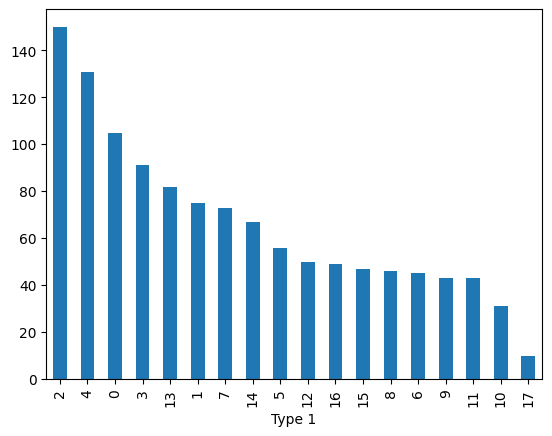

In [38]:
X = df_numeric.drop('Type 1', axis=1)
y = df_numeric['Type 1']
y.value_counts().plot.bar()


/home/matheus/miniconda3/envs/pytorch/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1000) in class 2 will be larger than the number of samples in the majority class (class #2 -> 150)
  warnings.warn(
/home/matheus/miniconda3/envs/pytorch/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1000) in class 4 will be larger than the number of samples in the majority class (class #2 -> 150)
  warnings.warn(
/home/matheus/miniconda3/envs/pytorch/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1000) in class 0 will be larger than the number of samples in the majority class (class #2 -> 150)
  warnings.warn(
/home/matheus/miniconda3/envs/pytorch/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (1000) in class 3

<Axes: xlabel='Type 1'>

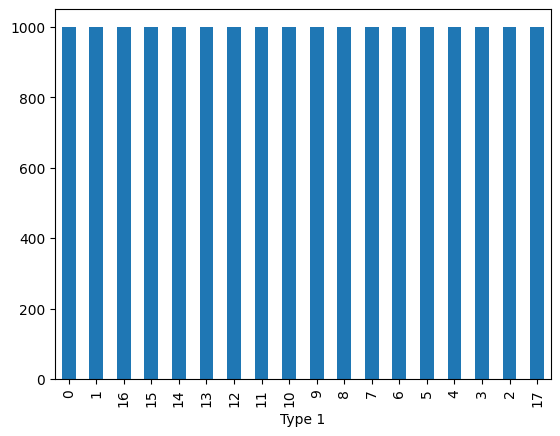

In [39]:
sampling_strategy = dict(zip(y.value_counts().index.tolist(), [1000 for _ in range(len(y.value_counts()))]))
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(X, y.astype(int))

y_res.value_counts().plot.bar()

In [40]:
df_numeric = X_res
df_numeric['Type 1'] = y_res
df_numeric = df_numeric.copy().sample(frac=1)

y = np.array(df_numeric['Type 1'], dtype=float)
df_numeric = df_numeric.drop('Type 1', axis=1)
df_normalized = (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())
matrix = df_normalized.to_numpy()
X = torch.from_numpy(matrix).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Separating in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1
14454,55,55,75,35,35,25,14
4131,107,139,139,53,53,79,3
7236,95,65,80,110,110,30,6
15531,85,110,76,65,82,56,15
16876,100,120,100,150,120,90,16
...,...,...,...,...,...,...,...
9636,70,65,60,125,90,65,9
12078,97,101,103,107,101,61,11
5465,100,123,75,57,75,80,4
12961,40,70,40,35,40,60,12


In [6]:
# Checking if the GPU is availible to run the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device availible: ', device)

device availible:  cuda


# Instaciating the model

In [7]:
# Model
class PokemonClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 18),
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.sequence(X)

# Instaciating the model
model = PokemonClassifier()
display(model)

PokemonClassifier(
  (sequence): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=18, bias=True)
  )
)

In [8]:
# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Write a training and evaluation loop for the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training the model

In [9]:
epochs = 15000

for epoch in range(epochs + 1):
    ### Training
    model.train()

    # 1. Forward
    pred = model(X_train).squeeze()

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    ### Testing
    model.eval()
    with torch.inference_mode():
        test_preds = torch.softmax(model(X_test), dim=1).argmax(dim=1)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 1000 == 0 or epoch == epochs:
        print('Epoch: {:<5d}   | Loss: {:<.5f}   | Acc: {:.2f}%'.format(epoch, loss, test_acc))

Epoch: 0       | Loss: 2.89733   | Acc: 7.42%
Epoch: 1000    | Loss: 1.08452   | Acc: 65.58%
Epoch: 2000    | Loss: 0.80755   | Acc: 72.81%
Epoch: 3000    | Loss: 0.63287   | Acc: 80.67%
Epoch: 4000    | Loss: 0.53287   | Acc: 83.97%
Epoch: 5000    | Loss: 0.46650   | Acc: 85.61%
Epoch: 6000    | Loss: 0.38643   | Acc: 88.53%
Epoch: 7000    | Loss: 1.94127   | Acc: 58.97%
Epoch: 8000    | Loss: 0.30425   | Acc: 90.64%
Epoch: 9000    | Loss: 0.26380   | Acc: 92.25%
Epoch: 10000   | Loss: 0.24543   | Acc: 92.14%
Epoch: 11000   | Loss: 0.21928   | Acc: 92.58%
Epoch: 12000   | Loss: 0.18895   | Acc: 94.36%
Epoch: 13000   | Loss: 0.17343   | Acc: 94.67%
Epoch: 14000   | Loss: 0.16132   | Acc: 95.06%
Epoch: 15000   | Loss: 0.14265   | Acc: 95.86%


# Testing after train

In [34]:
model.eval()
with torch.inference_mode():
    pred = torch.softmax(model(X_test), dim=1).argmax(dim=1)

a = random.randint(0, len(X_test) - 10)
b = a + 10

print(f'Predictions:   {pred[a:b].tolist()}')
print(f'Real:          {y_test[a:b].tolist()}')

Predictions:   [13, 4, 11, 11, 8, 13, 3, 5, 10, 9]
Real:          [13, 4, 11, 11, 8, 13, 3, 5, 10, 9]


In [35]:
X_test[a:b]

tensor([[0.3780, 0.5514, 0.3918, 0.6359, 0.3000, 0.3795],
        [0.1535, 0.2703, 0.1020, 0.1087, 0.0435, 0.4103],
        [0.2913, 0.4324, 0.7959, 0.2446, 0.1957, 0.1282],
        [0.3110, 0.3784, 0.5918, 0.3533, 0.5652, 0.2308],
        [0.4252, 0.4108, 0.3837, 0.3043, 0.2783, 0.1385],
        [0.4528, 0.2703, 0.3265, 0.5272, 0.3261, 0.1231],
        [0.2520, 0.2270, 0.2857, 0.3424, 0.2826, 0.4103],
        [0.2520, 0.6757, 0.2245, 0.3533, 0.1739, 0.3590],
        [0.1969, 0.2541, 0.3469, 0.3913, 0.3913, 0.4872],
        [0.2913, 0.4054, 0.4286, 0.2989, 0.3043, 0.2308]])